In [1]:
import pandas as pd
import numpy as np
df = pd.read_parquet('Uberdata.parquet')

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 6, Finished, Available, Finished)

In [2]:
df.head()

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 7, Finished, Available, Finished)

,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,...,sales_tax,congestion_surcharge,driver_pay,date,month,day,estimated_emissions,average_speed,estimated_levels,speed_category
0,B02764,B02764,07:06:55,07:11:30,07:12:31,07:20:02,169,244,1.241269,6.113682,...,0.451076,0.00,2.061787,01-01-2020,1,1,501.472510,12.181876,Medium,Congested
1,B02764,B02764,07:20:11,07:21:54,07:23:19,07:34:31,244,74,1.449269,6.511745,...,0.774727,0.00,2.489894,01-01-2020,1,1,585.504741,13.353739,Medium,Congested
2,B02764,B02764,07:34:12,07:36:42,07:38:21,07:41:18,74,74,0.587787,5.634790,...,0.494696,0.00,1.922788,01-01-2020,1,1,237.465813,6.258832,Low,Congested
3,B02887,B02887,07:22:43,07:23:00,07:23:51,07:42:20,48,112,1.747459,7.012115,...,1.166271,0.75,2.719979,01-01-2020,1,1,705.973521,14.952343,High,Congested
4,B02887,B02887,07:28:19,07:32:37,07:34:01,08:05:13,233,61,2.305581,7.535297,...,1.036737,0.75,3.025776,01-01-2020,1,1,931.454563,18.358247,High,Efficient


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 8, Finished, Available, Finished)

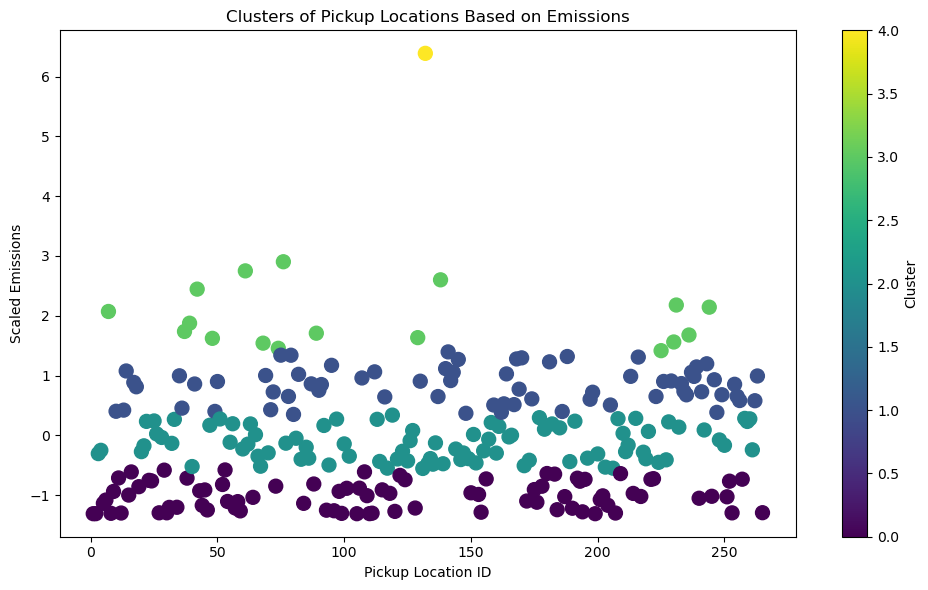

Cluster Emissions Summary:
   cluster  total_emissions
0        0       -84.886535
1        1        57.483449
2        2       -12.306254
3        3        33.319725
4        4         6.389615
High-Emission Clusters: [1, 3]


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
lookup_table = pd.read_csv("Users/aamahesh/taxi_zone_lookup (1).csv")
# Step 1: Prepare data for clustering
# Aggregate emissions by pickup zone
pickup_emissions = df.groupby('PULocationID')['estimated_emissions'].sum().reset_index()
pickup_emissions.rename(columns={'estimated_emissions': 'total_emissions'}, inplace=True)

# Step 2: Merge with lookup table using 'LocationID' instead of 'PULocationID'
pickup_data = pickup_emissions.merge(lookup_table, left_on='PULocationID', right_on='LocationID', how='left')

# Step 3: Scale numeric features for clustering
scaler = StandardScaler()
pickup_data[['total_emissions']] = scaler.fit_transform(pickup_data[['total_emissions']])

# Step 4: Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust clusters as needed
pickup_data['cluster'] = kmeans.fit_predict(pickup_data[['total_emissions']])

# Step 5: Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(pickup_data['PULocationID'], pickup_data['total_emissions'], c=pickup_data['cluster'], cmap='viridis', s=100)
plt.colorbar(label='Cluster')
plt.xlabel('Pickup Location ID')
plt.ylabel('Scaled Emissions')
plt.title('Clusters of Pickup Locations Based on Emissions')
plt.tight_layout()
plt.show()

# Step 6: Summarize cluster emissions
cluster_summary = pickup_data.groupby('cluster')['total_emissions'].sum().reset_index()
print("Cluster Emissions Summary:")
print(cluster_summary)

# Step 7: Focus on high-emission clusters for optimization
high_emission_clusters = cluster_summary.nlargest(2, 'total_emissions')['cluster'].tolist()
print(f"High-Emission Clusters: {high_emission_clusters}")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 9, Finished, Available, Finished)

For n_clusters = 2, the silhouette score is 0.39
For n_clusters = 3, the silhouette score is 0.38
For n_clusters = 4, the silhouette score is 0.36
For n_clusters = 5, the silhouette score is 0.37
For n_clusters = 6, the silhouette score is 0.36


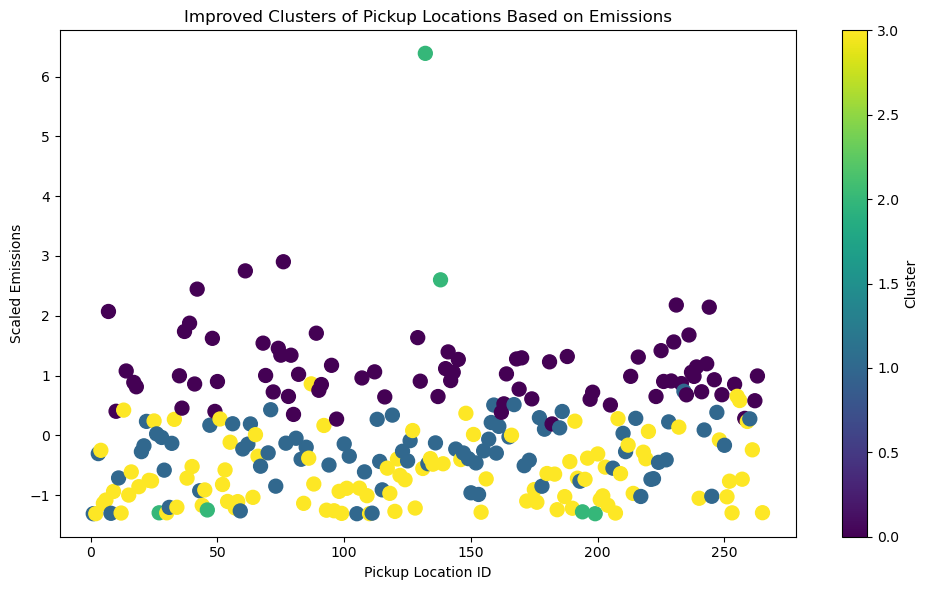

In [4]:
from sklearn.metrics import silhouette_score

# Step 1: Add more features for clustering
pickup_data['average_speed'] = df.groupby('PULocationID')['average_speed'].mean().reset_index()['average_speed']
pickup_data['trip_miles'] = df.groupby('PULocationID')['trip_miles'].mean().reset_index()['trip_miles']

# Step 2: Scale multiple features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pickup_data[['total_emissions', 'average_speed', 'trip_miles']])

# Step 3: Apply K-Means with different cluster sizes
for n_clusters in range(2, 7):  # Experiment with 2 to 6 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pickup_data['cluster'] = kmeans.fit_predict(scaled_features)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, pickup_data['cluster'])
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.2f}")

# Step 4: Final clustering with the best number of clusters (choose based on silhouette score)
optimal_clusters = 4  # Replace with the best cluster number
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
pickup_data['cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Visualize final clusters
plt.figure(figsize=(10, 6))
plt.scatter(pickup_data['PULocationID'], pickup_data['total_emissions'], c=pickup_data['cluster'], cmap='viridis', s=100)
plt.colorbar(label='Cluster')
plt.xlabel('Pickup Location ID')
plt.ylabel('Scaled Emissions')
plt.title('Improved Clusters of Pickup Locations Based on Emissions')
plt.tight_layout()
plt.show()


In [5]:
# Filter high-emission clusters (e.g., Cluster 3)
high_emission_zones = pickup_data[pickup_data['cluster'] == 3]
print("High-Emission Zones in Cluster 3:")
print(high_emission_zones)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 10, Finished, Available, Finished)

High-Emission Zones in Cluster 3:
     PULocationID  total_emissions  LocationID        Borough  \
1               2        -1.311478           2         Queens   
3               4        -0.251566           4      Manhattan   
4               5        -1.138420           5  Staten Island   
5               6        -1.083340           6  Staten Island   
8               9        -0.939917           9         Queens   
..            ...              ...         ...            ...   
253           256         0.581491         256       Brooklyn   
254           257        -0.734814         257       Brooklyn   
256           259         0.231437         259          Bronx   
258           261        -0.243323         261      Manhattan   
261           265        -1.295162         265            NaN   

                          Zone service_zone  cluster  average_speed  \
1                  Jamaica Bay    Boro Zone        3      16.456596   
3                Alphabet City  Yellow Zone

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 11, Finished, Available, Finished)

Top High-Emission Zones for Optimization:
     PULocationID    Borough                          Zone  total_emissions  \
86             87  Manhattan      Financial District North         0.860133   
252           255   Brooklyn     Williamsburg (North Side)         0.651962   
253           256   Brooklyn     Williamsburg (South Side)         0.581491   
12             13  Manhattan             Battery Park City         0.420973   
145           148  Manhattan               Lower East Side         0.367858   
205           208      Bronx  Schuylerville/Edgewater Park         0.277648   
50             51      Bronx                    Co-Op City         0.272950   
32             33   Brooklyn              Brooklyn Heights         0.266359   
24             25   Brooklyn                   Boerum Hill         0.239667   
188           191     Queens                Queens Village         0.235826   

     average_speed  
86       14.392077  
252      14.306908  
253      13.600248  
12  

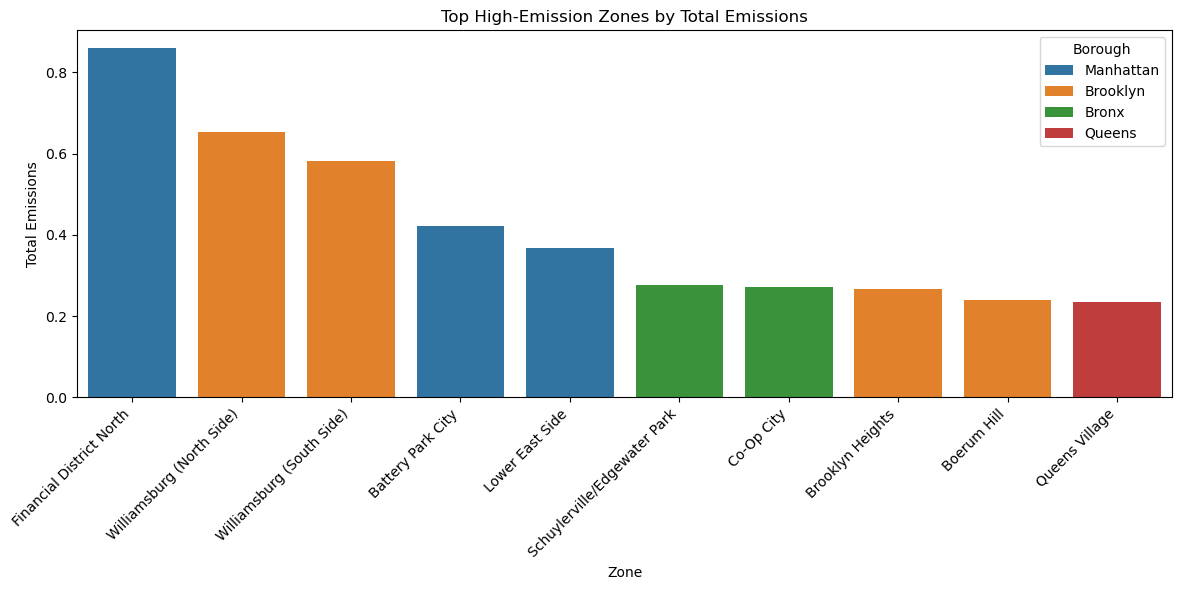

In [6]:
# Sort by total emissions to identify zones contributing most to emissions
top_high_emission_zones = high_emission_zones.sort_values(by='total_emissions', ascending=False).head(10)
print("Top High-Emission Zones for Optimization:")
print(top_high_emission_zones[['PULocationID', 'Borough', 'Zone', 'total_emissions', 'average_speed']])

# Visualize high-emission zones
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_high_emission_zones, x='Zone', y='total_emissions', hue='Borough', dodge=False)
plt.title('Top High-Emission Zones by Total Emissions')
plt.ylabel('Total Emissions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [7]:
# Updated manually defined nearby zones as a dictionary
nearby_zones_dict = {
    # Bronx
    "3": ["18", "20", "31"],
    "18": ["3", "20", "31"],
    "20": ["18", "31", "32"],
    "31": ["3", "18", "20", "32"],
    "32": ["31", "20", "59"],
    "46": ["47", "58"],
    "47": ["46", "59"],
    "51": ["58", "60"],
    "58": ["51", "46", "59"],
    "59": ["47", "58", "60"],
    "60": ["59", "78", "81"],
    "69": ["78", "60", "94"],
    "78": ["60", "69", "94"],
    "81": ["60", "94", "119"],
    "94": ["78", "81", "136"],
    "119": ["81", "126"],
    "126": ["119", "136", "147"],
    "136": ["94", "126", "200"],
    "147": ["126", "167", "168"],
    "159": ["167", "168", "169"],
    "167": ["159", "169", "185"],
    "168": ["167", "159", "183"],
    "169": ["167", "185", "174"],
    "174": ["169", "185", "182"],
    "182": ["174", "185", "183"],
    "183": ["182", "185", "208"],
    "185": ["183", "174", "208"],
    "199": ["200", "208", "212"],
    "200": ["199", "208", "220"],
    "208": ["199", "200", "212"],
    "212": ["199", "213", "220"],
    "213": ["212", "220", "235"],
    "220": ["213", "200", "235"],
    "235": ["213", "220", "240"],
    "240": ["235", "241", "242"],
    "241": ["240", "242", "247"],
    "242": ["240", "241", "250"],
    "247": ["241", "250", "259"],
    "250": ["247", "259", "254"],
    "254": ["250", "259"],
    "259": ["247", "254"],

    # Brooklyn
    "11": ["14", "17", "22"],
    "14": ["11", "17", "29"],
    "17": ["11", "14", "25"],
    "21": ["22", "25", "35"],
    "22": ["21", "25", "29"],
    "25": ["21", "17", "26"],
    "26": ["25", "35", "37"],
    "29": ["22", "26", "35"],
    "33": ["25", "26", "35"],
    "35": ["29", "37", "39"],
    "36": ["35", "39", "40"],
    "37": ["35", "36", "49"],
    "39": ["36", "55", "49"],
    "40": ["36", "49", "52"],
    "49": ["37", "40", "55"],
    "52": ["40", "54", "61"],
    "54": ["52", "61", "63"],
    "55": ["39", "49", "63"],
    "61": ["52", "62", "63"],
    "62": ["61", "63", "65"],
    "63": ["61", "62", "67"],
    "65": ["62", "67", "80"],
    "66": ["67", "80", "85"],
    "67": ["63", "66", "80"],
    "71": ["72", "76", "85"],
    "72": ["71", "76", "80"],
    "76": ["72", "80", "85"],
    "77": ["76", "85", "97"],
    "80": ["72", "77", "97"],
    "85": ["71", "77", "97"],
    "89": ["85", "97", "106"],
    "97": ["77", "89", "112"],
    "106": ["97", "108", "112"],
    "108": ["106", "112", "123"],
    "111": ["123", "133", "149"],
    "112": ["97", "108", "133"],
    "123": ["108", "111", "133"],
    "133": ["111", "123", "165"],
    "149": ["111", "165", "177"],
    "165": ["133", "149", "177"],
    "177": ["165", "178", "188"],
    "178": ["177", "190", "195"],
    "188": ["177", "190", "225"],
    "189": ["190", "225", "228"],
    "190": ["178", "189", "210"],
    "210": ["178", "190", "222"],
    "217": ["222", "225", "256"],
    "222": ["210", "217", "257"],
    "225": ["189", "217", "255"],
    "227": ["228", "257"],
    "228": ["225", "255"],

    # Manhattan
    "4": ["12", "13", "24"],
    "12": ["4", "13", "24"],
    "13": ["4", "12", "41"],
    "24": ["4", "12", "43"],
    "41": ["13", "43", "45"],
    "43": ["24", "41", "48"],
    "45": ["41", "48", "50"],
    "48": ["43", "50", "68"],
    "50": ["45", "68", "74"],
    "68": ["48", "50", "79"],
    "74": ["50", "75", "79"],
    "75": ["74", "79", "87"],
    "79": ["68", "75", "88"],
    "87": ["75", "88", "90"],
    "88": ["79", "87", "90"],
    "90": ["87", "88", "100"],

    # Queens
    "2": ["7", "8", "9"],
    "7": ["2", "8", "10"],
    "8": ["7", "9", "15"],
    "9": ["8", "10", "15"],
    "10": ["7", "9", "16"],
    "15": ["8", "10", "19"],

    # Staten Island
    "5": ["6", "23", "44"],
    "6": ["5", "23", "44"],
    "23": ["5", "6", "44"],
    "44": ["5", "6", "23"],

    # Edge Cases
    "264": ["265"],  # Unknown near Outside NYC
    "265": ["264"]   # Outside NYC near Unknown
}


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 12, Finished, Available, Finished)

In [8]:
group_3_df = pickup_data[pickup_data['cluster'] == 3]


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 13, Finished, Available, Finished)

In [9]:
pickup_data.head()

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 14, Finished, Available, Finished)

,PULocationID,total_emissions,LocationID,Borough,Zone,service_zone,cluster,average_speed,trip_miles
0,1,-1.311956,1,EWR,Newark Airport,EWR,1,9.733914,0.993074
1,2,-1.311478,2,Queens,Jamaica Bay,Boro Zone,3,16.456596,1.927215
2,3,-0.306611,3,Bronx,Allerton/Pelham Gardens,Boro Zone,1,12.385846,1.408972
3,4,-0.251566,4,Manhattan,Alphabet City,Yellow Zone,3,13.094468,1.520516
4,5,-1.138420,5,Staten Island,Arden Heights,Boro Zone,3,14.191382,1.603249


In [10]:
# Aggregate emissions, trip miles, and average speed for Group 3
group_3_analysis = pickup_data.groupby('PULocationID').agg({
    'total_emissions': 'sum',
    'trip_miles': 'sum',
    'average_speed': 'mean'
}).reset_index()

# Sort by emissions to identify the most problematic zones
high_emission_zones_group_3 = group_3_analysis.sort_values(by='total_emissions', ascending=False)
print("High-Emission Zones in Group 3:")
print(high_emission_zones_group_3.head(10))


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 15, Finished, Available, Finished)

High-Emission Zones in Group 3:
     PULocationID  total_emissions  trip_miles  average_speed
129           132         6.389615    2.620085      20.539901
75             76         2.903139    1.360921      11.856625
60             61         2.750458    1.451130      12.261239
135           138         2.600819    2.337908      18.488321
41             42         2.445148    1.426032      12.346260
228           231         2.179126    1.499018      12.792278
241           244         2.143244    1.630929      13.986849
6               7         2.071176    1.478353      12.682078
38             39         1.875209    1.390558      12.100403
36             37         1.736940    1.534336      12.830331


In [11]:
def reroute_to_nearby(current_zone, nearby_zones_dict):
    """
    Reroute a trip to a nearby zone.
    
    Parameters:
    - current_zone (str): The current pickup zone.
    - nearby_zones_dict (dict): Dictionary mapping zones to their nearby zones.
    
    Returns:
    - str: The rerouted zone, or the current zone if no alternatives are available.
    """
    if current_zone in nearby_zones_dict:  # Ensure the current zone has nearby zones
        nearby_zones = nearby_zones_dict[current_zone]
        if nearby_zones:  # Ensure there are nearby zones to choose from
            return random.choice(nearby_zones)  # Randomly select a nearby zone
    return current_zone  # Return the current zone if no rerouting is possible


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 16, Finished, Available, Finished)

In [14]:
import random 
# Add rerouted zones for Group 3 only using .loc to avoid SettingWithCopyWarning
group_3_df.loc[:, 'rerouted_zone'] = group_3_df['PULocationID'].astype(str).apply(
    lambda x: reroute_to_nearby(x, nearby_zones_dict)
)

# Calculate emissions after rerouting in Group 3
group_3_rerouted_emissions = group_3_df.groupby('rerouted_zone')['total_emissions'].sum().reset_index()
group_3_rerouted_emissions.rename(columns={'total_emissions': 'rerouted_emissions'}, inplace=True)

# Compare emissions before and after rerouting for Group 3
total_emissions_group_3_before = group_3_df['total_emissions'].sum()
total_emissions_group_3_after = group_3_rerouted_emissions['rerouted_emissions'].sum()

print(f"Group 3 Total Emissions Before Rerouting: {total_emissions_group_3_before:.2f}")
print(f"Group 3 Total Emissions After Rerouting: {total_emissions_group_3_after:.2f}")
print(f"Group 3 Emissions Reduction: {total_emissions_group_3_before - total_emissions_group_3_after:.2f}")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 19, Finished, Available, Finished)

/tmp/ipykernel_8453/197139659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_3_df.loc[:, 'rerouted_zone'] = group_3_df['PULocationID'].astype(str).apply(


In [15]:
print(group_3_df[['PULocationID', 'rerouted_zone']].head())


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 20, Finished, Available, Finished)

   PULocationID rerouted_zone
1             2             9
3             4            13
4             5            23
5             6             5
8             9            15


In [16]:
group_3_rerouted_emissions = group_3_df.groupby('rerouted_zone')['total_emissions'].sum().reset_index()
group_3_rerouted_emissions.rename(columns={'total_emissions': 'rerouted_emissions'}, inplace=True)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 21, Finished, Available, Finished)

In [17]:
total_emissions_group_3_before = group_3_df['total_emissions'].sum()
total_emissions_group_3_after = group_3_rerouted_emissions['rerouted_emissions'].sum()

print(f"Group 3 Total Emissions Before Rerouting: {total_emissions_group_3_before:.2f}")
print(f"Group 3 Total Emissions After Rerouting: {total_emissions_group_3_after:.2f}")
print(f"Group 3 Emissions Reduction: {total_emissions_group_3_before - total_emissions_group_3_after:.2f}")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 22, Finished, Available, Finished)

Group 3 Total Emissions Before Rerouting: -63.20
Group 3 Total Emissions After Rerouting: -63.20
Group 3 Emissions Reduction: 0.00


In [18]:
print(group_3_df[['PULocationID', 'total_emissions']].head())


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 23, Finished, Available, Finished)

   PULocationID  total_emissions
1             2        -1.311478
3             4        -0.251566
4             5        -1.138420
5             6        -1.083340
8             9        -0.939917


In [19]:
# Recalculate total_emissions for Group 3
group_3_df['total_emissions'] = group_3_df['PULocationID'].map(
    lambda x: df.loc[df['PULocationID'] == x, 'estimated_emissions'].sum()
)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 24, Finished, Available, Finished)

/tmp/ipykernel_8453/2203337541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_3_df['total_emissions'] = group_3_df['PULocationID'].map(


In [20]:
print(group_3_df['total_emissions'])

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 25, Finished, Available, Finished)

1      4.593709e+04
3      9.497573e+07
4      1.554575e+07
5      2.047886e+07
8      3.332441e+07
           ...     
253    1.695875e+08
254    5.169422e+07
256    1.382353e+08
258    9.571401e+07
261    1.507341e+06
Name: total_emissions, Length: 99, dtype: float64


In [21]:
# Replace negative emissions with 0
df['estimated_emissions'] = df['estimated_emissions'].clip(lower=0)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 26, Finished, Available, Finished)

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 27, Finished, Available, Finished)

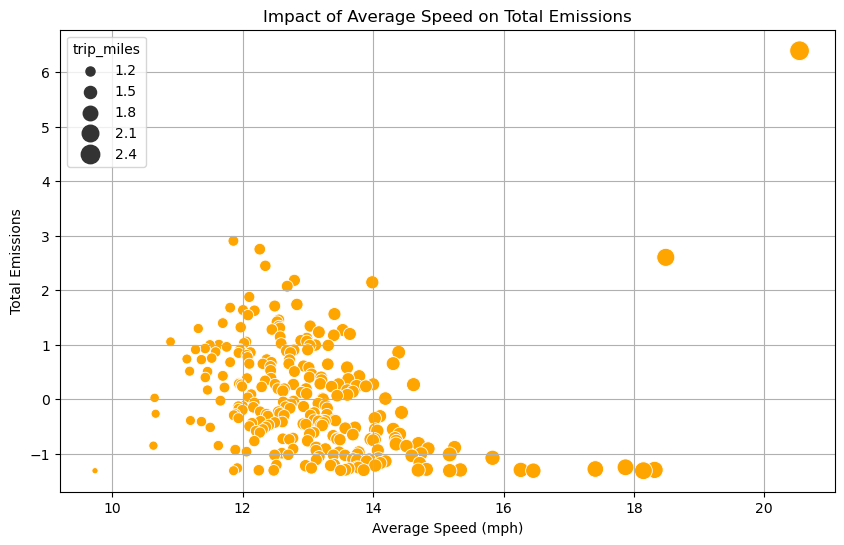

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Relationship between average speed and total emissions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=high_emission_zones_group_3, x='average_speed', y='total_emissions', size='trip_miles', sizes=(20, 200), color='orange')
plt.title("Impact of Average Speed on Total Emissions")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Total Emissions")
plt.grid()
plt.show()


In [23]:
# Identify zones with average speed < 14 mph and high emissions
high_emission_congested_zones = high_emission_zones_group_3[
    (high_emission_zones_group_3['average_speed'] < 14) &
    (high_emission_zones_group_3['total_emissions'] > high_emission_zones_group_3['total_emissions'].mean())
]

# Map these zones to suggested nearby zones using the nearby_zones_dict
def map_nearby_zones(zone_dict, pulocation_ids):
    suggestions = {}
    for pulocation in pulocation_ids:
        if str(pulocation) in zone_dict:
            suggestions[pulocation] = zone_dict[str(pulocation)]
        else:
            suggestions[pulocation] = ["No Nearby Zones Found"]
    return suggestions

# Fetch alternate zones
congested_ids = high_emission_congested_zones['PULocationID'].tolist()
alternate_zones = map_nearby_zones(nearby_zones_dict, congested_ids)

# Merge alternate zone suggestions into the data
high_emission_congested_zones['Suggested_Routes'] = high_emission_congested_zones['PULocationID'].map(
    lambda x: alternate_zones.get(x, [])
)

# Display the table with alternate suggestions
print("High-Emission Congested Zones with Alternate Route Suggestions:")
print(high_emission_congested_zones[['PULocationID', 'total_emissions', 'average_speed', 'Suggested_Routes']])

# Save the output to a CSV file for reporting
high_emission_congested_zones.to_csv("route_optimization_suggestions.csv", index=False)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 28, Finished, Available, Finished)

/tmp/ipykernel_8453/4111593320.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_emission_congested_zones['Suggested_Routes'] = high_emission_congested_zones['PULocationID'].map(


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 29, Finished, Available, Finished)

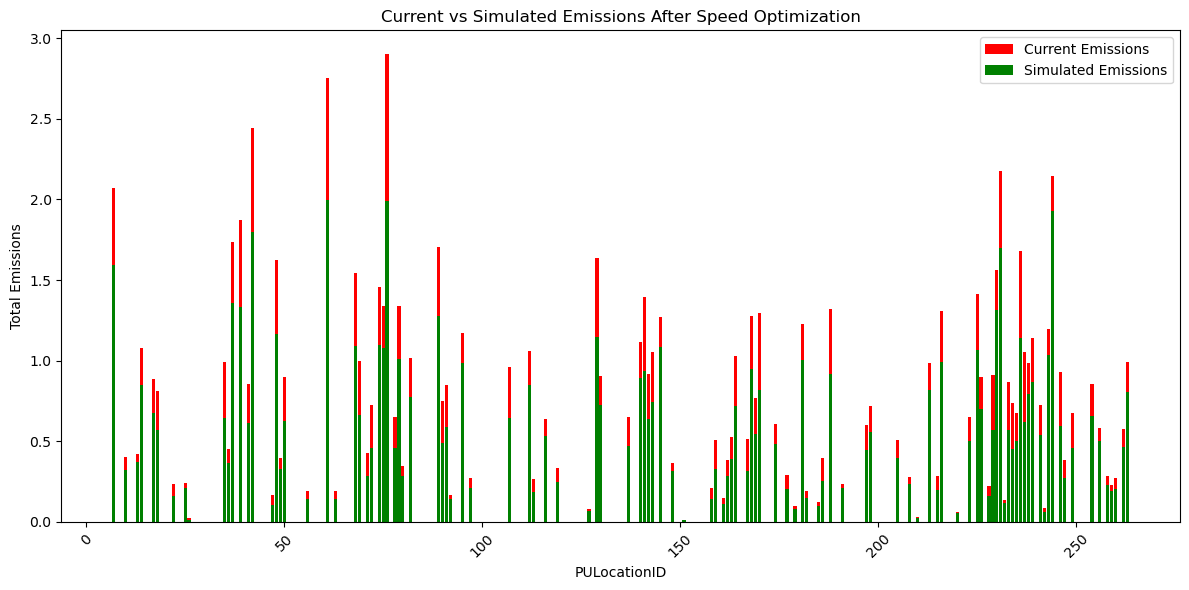

Top Zones for Emission Reductions:
    PULocationID  total_emissions  simulated_emissions  emission_reduction  \
0             76         2.903139             1.990574            0.912565   
1             61         2.750458             1.997174            0.753285   
2             42         2.445148             1.796269            0.648879   
6             39         1.875209             1.331474            0.543735   
9            236         1.677846             1.142189            0.535657   
10           129         1.633775             1.144387            0.489387   
3            231         2.179126             1.698036            0.481090   
5              7         2.071176             1.591094            0.480082   
21           170         1.295347             0.818411            0.476936   
16           141         1.394988             0.933698            0.461290   

             Suggested_Routes  
0          ['72', '80', '85']  
1          ['52', '62', '63']  
2   ['No N

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated data
data = pd.read_csv("route_optimization_suggestions.csv")

# Define the optimal speed and emission reduction factor (assume ~10% reduction per mph gained)
optimal_speed = 15  # mph
reduction_factor_per_mph = 0.1 

# Calculate simulated new emissions
def calculate_new_emissions(row, optimal_speed, reduction_factor):
    if row['average_speed'] < optimal_speed:
        speed_gain = optimal_speed - row['average_speed']
        reduction_factor_total = 1 - (speed_gain * reduction_factor)
        return row['total_emissions'] * max(reduction_factor_total, 0.5) 
    return row['total_emissions']

data['simulated_emissions'] = data.apply(
    lambda row: calculate_new_emissions(row, optimal_speed, reduction_factor_per_mph), axis=1
)

# Compare before and after
data['emission_reduction'] = data['total_emissions'] - data['simulated_emissions']

# Visualize the results
plt.figure(figsize=(12, 6))
plt.bar(data['PULocationID'], data['total_emissions'], label='Current Emissions', color='red')
plt.bar(data['PULocationID'], data['simulated_emissions'], label='Simulated Emissions', color='green')
plt.xlabel("PULocationID")
plt.ylabel("Total Emissions")
plt.title("Current vs Simulated Emissions After Speed Optimization")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top zones with highest reduction potential
top_reductions = data.sort_values(by='emission_reduction', ascending=False).head(10)
print("Top Zones for Emission Reductions:")
print(top_reductions[['PULocationID', 'total_emissions', 'simulated_emissions', 'emission_reduction', 'Suggested_Routes']])


In [26]:
# Load lookup table for borough and zone mapping
lookup_df = pd.read_csv("Users/aamahesh/taxi_zone_lookup (1).csv")  # Replace with your lookup table path

# Merge the top emission reduction data with the lookup table
top_reduction_with_zones = pd.merge(
    top_reductions, 
    lookup_df, 
    left_on='PULocationID', 
    right_on='LocationID', 
    how='left'
)

# Display the merged data with zone and borough information
print("Top Zones with Emission Reductions and Zone Information:")
print(top_reduction_with_zones[['PULocationID', 'Borough', 'Zone', 'total_emissions', 
                                'simulated_emissions', 'emission_reduction', 'Suggested_Routes']])

# Save this to a CSV file for reporting
top_reduction_with_zones.to_csv("top_emission_reduction_with_zones.csv", index=False)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 31, Finished, Available, Finished)

Top Zones with Emission Reductions and Zone Information:
   PULocationID    Borough                   Zone  total_emissions  \
0            76   Brooklyn          East New York         2.903139   
1            61   Brooklyn    Crown Heights North         2.750458   
2            42  Manhattan   Central Harlem North         2.445148   
3            39   Brooklyn               Canarsie         1.875209   
4           236  Manhattan  Upper East Side North         1.677846   
5           129     Queens        Jackson Heights         1.633775   
6           231  Manhattan   TriBeCa/Civic Center         2.179126   
7             7     Queens                Astoria         2.071176   
8           170  Manhattan            Murray Hill         1.295347   
9           141  Manhattan        Lenox Hill West         1.394988   

   simulated_emissions  emission_reduction           Suggested_Routes  
0             1.990574            0.912565         ['72', '80', '85']  
1             1.997174      

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 32, Finished, Available, Finished)

Cluster-Level Summary:
   cluster  total_emissions  average_speed  trip_miles
0        0        83.099040      12.470460  111.848117
1        1       -23.753696      12.137662  111.795609
2        2         3.851722      18.461361   13.690952
3        3       -63.197067      13.867414  159.441099


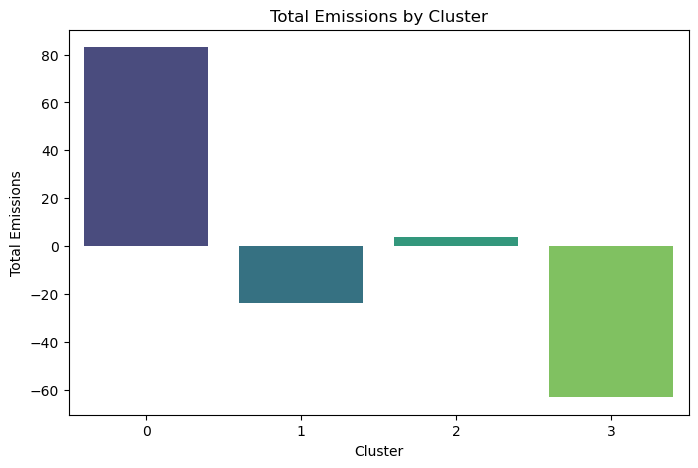

In [27]:
# Analyze emissions and speeds across clusters
cluster_summary = pickup_data.groupby('cluster').agg({
    'total_emissions': 'sum',
    'average_speed': 'mean',
    'trip_miles': 'sum'
}).reset_index()

print("Cluster-Level Summary:")
print(cluster_summary)

# Visualize emissions by cluster
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_summary, x='cluster', y='total_emissions', palette='viridis')
plt.title("Total Emissions by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Emissions")
plt.show()


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 33, Finished, Available, Finished)

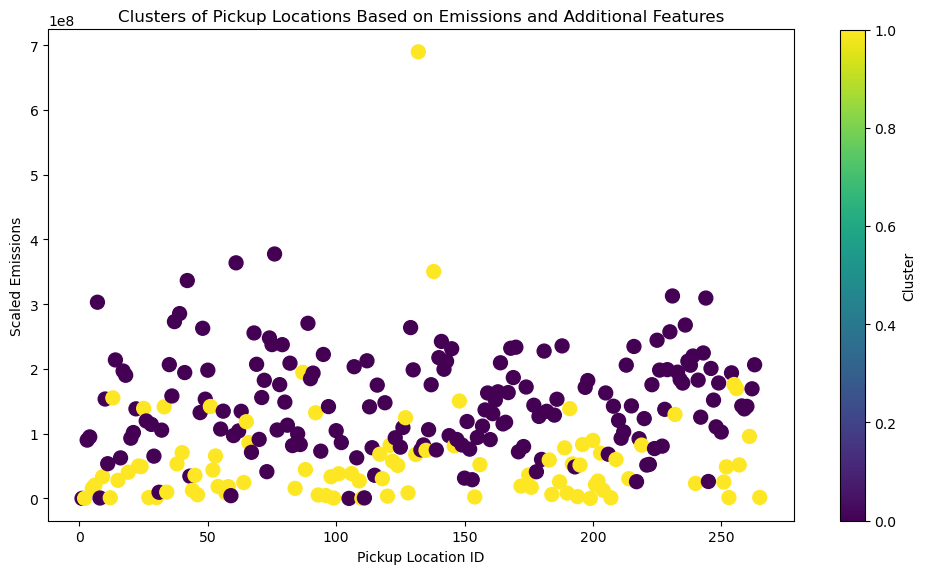

Cluster Summary:
   cluster  total_emissions  average_speed  trip_miles
0        0     2.527489e+10      12.382051    1.433564
1        1     5.511929e+09      14.279642    1.668920


In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Prepare data for clustering
pickup_emissions = df.groupby('PULocationID').agg({
    'estimated_emissions': 'sum',
    'average_speed': 'mean',
    'trip_miles': 'mean'
}).reset_index()
pickup_emissions.rename(columns={'estimated_emissions': 'total_emissions'}, inplace=True)

# Merge with lookup table
pickup_data = pickup_emissions.merge(lookup_table, left_on='PULocationID', right_on='LocationID', how='left')

# Step 2: Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pickup_data[['total_emissions', 'average_speed', 'trip_miles']])

# Step 3: Apply K-Means with the optimal clusters
kmeans = KMeans(n_clusters=2, random_state=42)  # Use the best silhouette score result
pickup_data['cluster'] = kmeans.fit_predict(scaled_features)

# Step 4: Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(pickup_data['PULocationID'], pickup_data['total_emissions'], c=pickup_data['cluster'], cmap='viridis', s=100)
plt.colorbar(label='Cluster')
plt.xlabel('Pickup Location ID')
plt.ylabel('Scaled Emissions')
plt.title('Clusters of Pickup Locations Based on Emissions and Additional Features')
plt.tight_layout()
plt.show()

# Step 5: Summarize cluster emissions
cluster_summary = pickup_data.groupby('cluster').agg({
    'total_emissions': 'sum',
    'average_speed': 'mean',
    'trip_miles': 'mean'
}).reset_index()

print("Cluster Summary:")
print(cluster_summary)


In [29]:
# Filter and rank Cluster 0 zones by total emissions
high_emission_zones = pickup_data[pickup_data['cluster'] == 0]
top_high_emission_zones = high_emission_zones.sort_values(by='total_emissions', ascending=False)

print("Top High-Emission Zones in Cluster 0:")
print(top_high_emission_zones[['PULocationID', 'total_emissions', 'average_speed', 'trip_miles']].head(10))


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 34, Finished, Available, Finished)

Top High-Emission Zones in Cluster 0:
     PULocationID  total_emissions  average_speed  trip_miles
75             76     3.775231e+08      11.856625    1.360921
60             61     3.638484e+08      12.261239    1.451130
41             42     3.365037e+08      12.346260    1.426032
228           231     3.126777e+08      12.792278    1.499018
241           244     3.094640e+08      13.986849    1.630929
6               7     3.030093e+08      12.682078    1.478353
38             39     2.854577e+08      12.100403    1.390558
36             37     2.730739e+08      12.830331    1.534336
88             89     2.704676e+08      12.490145    1.481971
233           236     2.677812e+08      11.807472    1.363702


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 35, Finished, Available, Finished)

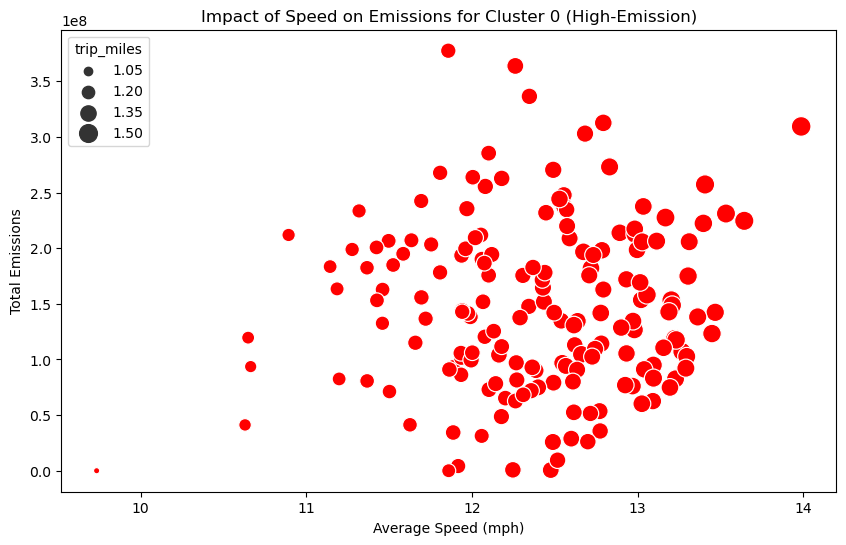

In [30]:
import seaborn as sns

# Scatter plot: Speed vs Emissions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=high_emission_zones, x='average_speed', y='total_emissions', size='trip_miles', sizes=(20, 200), color='red')
plt.title("Impact of Speed on Emissions for Cluster 0 (High-Emission)")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Total Emissions")
plt.show()


In [39]:
# Step 1: Create a mapping dictionary from lookup_table
zone_info = lookup_table.set_index('LocationID')[['Borough', 'Zone']].to_dict(orient='index')

# Step 2: Update the function to map Borough and Zone names
def suggest_alternate_routes_with_details(zone_dict, pulocation_ids, zone_info):
    suggestions = {}
    for pulocation in pulocation_ids:
        # Get current zone's Borough and Zone name
        current_zone = zone_info.get(pulocation, {'Borough': 'Unknown', 'Zone': 'Unknown'})
        current_info = f"{current_zone['Borough']} - {current_zone['Zone']}"

        # Find alternate routes
        if str(pulocation) in zone_dict:
            alternates = zone_dict[str(pulocation)]
            # Map alternate PULocationIDs to Borough and Zone names
            alternate_details = [
                f"{alt_id}: {zone_info.get(int(alt_id), {'Borough': 'Unknown', 'Zone': 'Unknown'})['Borough']} - {zone_info.get(int(alt_id), {'Borough': 'Unknown', 'Zone': 'Unknown'})['Zone']}" 
                for alt_id in alternates
            ]
            suggestions[current_info] = alternate_details
        else:
            suggestions[current_info] = "No Nearby Zones Found"
    return suggestions

# Step 3: Suggest routes with detailed info
cluster_0_ids = top_high_emission_zones['PULocationID'].head(10).tolist()
alternate_routes_detailed = suggest_alternate_routes_with_details(nearby_zones_dict, cluster_0_ids, zone_info)

# Step 4: Display suggestions with Borough and Zone names
for zone, alternatives in alternate_routes_detailed.items():
    print(f"Zone: {zone} -> Alternate Routes: {alternatives}")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 44, Finished, Available, Finished)

Zone: Brooklyn - East New York -> Alternate Routes: ['72: Brooklyn - East Flatbush/Remsen Village', '80: Brooklyn - East Williamsburg', '85: Brooklyn - Erasmus']
Zone: Brooklyn - Crown Heights North -> Alternate Routes: ['52: Brooklyn - Cobble Hill', '62: Brooklyn - Crown Heights South', '63: Brooklyn - Cypress Hills']
Zone: Manhattan - Central Harlem North -> Alternate Routes: No Nearby Zones Found
Zone: Manhattan - TriBeCa/Civic Center -> Alternate Routes: No Nearby Zones Found
Zone: Manhattan - Washington Heights South -> Alternate Routes: No Nearby Zones Found
Zone: Queens - Astoria -> Alternate Routes: ['2: Queens - Jamaica Bay', '8: Queens - Astoria Park', '10: Queens - Baisley Park']
Zone: Brooklyn - Canarsie -> Alternate Routes: ['36: Brooklyn - Bushwick North', '55: Brooklyn - Coney Island', '49: Brooklyn - Clinton Hill']
Zone: Brooklyn - Bushwick South -> Alternate Routes: ['35: Brooklyn - Brownsville', '36: Brooklyn - Bushwick North', '49: Brooklyn - Clinton Hill']
Zone: Bro

In [32]:
# Simulate emissions with speed improvements
def simulate_emission_reduction(row, speed_increase_percent):
    new_speed = row['average_speed'] * (1 + speed_increase_percent / 100)
    if new_speed > row['average_speed']:
        reduction_factor = 1 - (speed_increase_percent * 0.05)  # Assume 5% reduction per 10% speed increase
        return row['total_emissions'] * reduction_factor
    return row['total_emissions']

# Apply speed improvements (10% and 20%)
high_emission_zones['emissions_10pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=10)
high_emission_zones['emissions_20pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=20)

# Compare reductions
high_emission_zones['reduction_10pct'] = high_emission_zones['total_emissions'] - high_emission_zones['emissions_10pct']
high_emission_zones['reduction_20pct'] = high_emission_zones['total_emissions'] - high_emission_zones['emissions_20pct']

# Display results
print("Simulated Emission Reductions:")
print(high_emission_zones[['PULocationID', 'total_emissions', 'emissions_10pct', 'reduction_10pct', 'emissions_20pct', 'reduction_20pct']])


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 37, Finished, Available, Finished)

/tmp/ipykernel_8453/4084303047.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_emission_zones['emissions_10pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=10)
/tmp/ipykernel_8453/4084303047.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_emission_zones['emissions_20pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=20)
/tmp/ipykernel_8453/4084303047.py:14: SettingWithCopyWarning: 
A value is trying t

StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 38, Finished, Available, Finished)

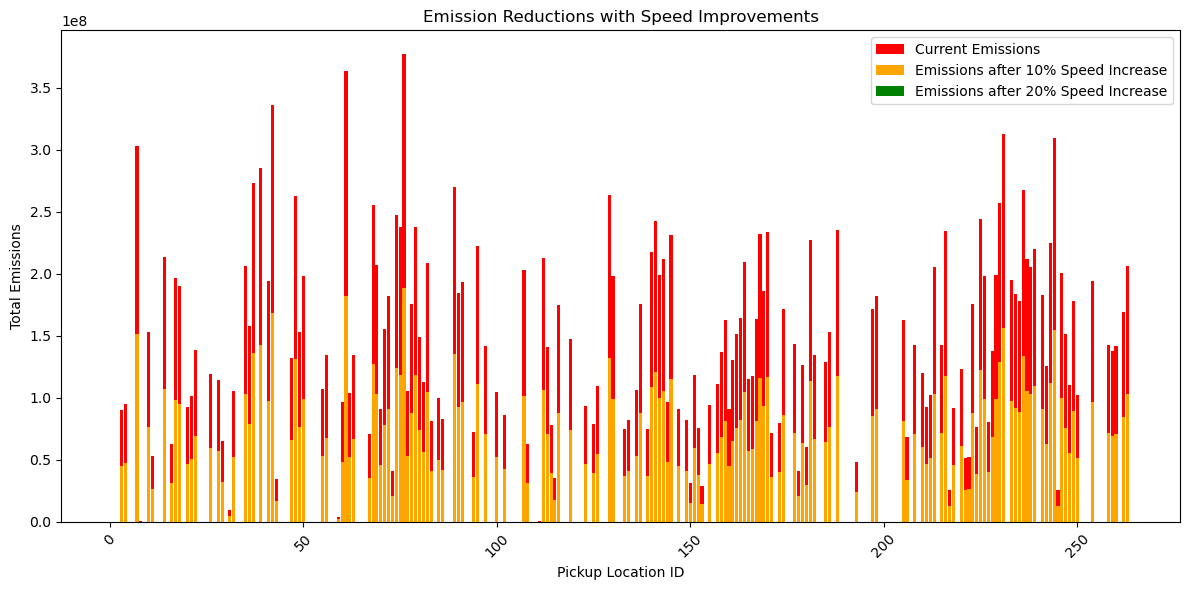

In [33]:
# Visualize emission reductions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(high_emission_zones['PULocationID'], high_emission_zones['total_emissions'], label='Current Emissions', color='red')
plt.bar(high_emission_zones['PULocationID'], high_emission_zones['emissions_10pct'], label='Emissions after 10% Speed Increase', color='orange')
plt.bar(high_emission_zones['PULocationID'], high_emission_zones['emissions_20pct'], label='Emissions after 20% Speed Increase', color='green')
plt.xlabel("Pickup Location ID")
plt.ylabel("Total Emissions")
plt.title("Emission Reductions with Speed Improvements")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
# Step 1: Merge high-emission zones with the lookup table
# Use 'LocationID' only once and specify suffixes to avoid duplication
high_emission_zones = high_emission_zones.merge(
    lookup_table[['LocationID', 'Borough', 'Zone']], 
    left_on='PULocationID', 
    right_on='LocationID', 
    how='left',
    suffixes=('', '_lookup')  # Avoid default '_x' and '_y'
)

# Step 2: Drop the redundant 'LocationID' column
high_emission_zones = high_emission_zones.drop(columns=['LocationID'])

# Step 3: Select relevant columns and display
high_emission_zones_summary = high_emission_zones[[
    'PULocationID', 'Borough', 'Zone', 'total_emissions', 
    'average_speed', 'trip_miles', 'reduction_10pct', 'reduction_20pct'
]]

# Display the updated summary
print("High-Emission Zones with Borough and Zone:")
print(high_emission_zones_summary)

# Step 4: Save the results for reporting
high_emission_zones_summary.to_csv("high_emission_zones_with_details.csv", index=False)
print("File saved as 'high_emission_zones_with_details.csv'")


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 43, Finished, Available, Finished)

High-Emission Zones with Borough and Zone:
     PULocationID    Borough                     Zone  total_emissions  \
0               1        EWR           Newark Airport     3.209616e+03   
1               3      Bronx  Allerton/Pelham Gardens     9.004567e+07   
2               4  Manhattan            Alphabet City     9.497573e+07   
3               7     Queens                  Astoria     3.030093e+08   
4               8     Queens             Astoria Park     5.975180e+05   
..            ...        ...                      ...              ...   
167           258     Queens                Woodhaven     1.428079e+08   
168           259      Bronx       Woodlawn/Wakefield     1.382353e+08   
169           260     Queens                 Woodside     1.421223e+08   
170           262  Manhattan           Yorkville East     1.692900e+08   
171           263  Manhattan           Yorkville West     2.063839e+08   

     average_speed  trip_miles  reduction_10pct  reduction_20pct  
0

In [36]:
# Step 1: Load the taxi_zone file (if not already loaded)
taxi_zone = pd.read_csv("Users/aamahesh/taxi_zone_lookup (1).csv") 

# Step 2: Merge high-emission zones with taxi_zone to add Borough and Zone
high_emission_zones = high_emission_zones.merge(
    taxi_zone, left_on='PULocationID', right_on='LocationID', how='left'
)

# Step 3: Reorganize and include Borough and Zone in your reduction summary
reduction_summary = high_emission_zones[[
    'Borough', 'Zone', 'total_emissions', 
    'absolute_reduction_10pct', 'percentage_reduction_10pct',
    'absolute_reduction_20pct', 'percentage_reduction_20pct'
]]

# Step 4: Display the final reduction summary
print("Emission Reduction Summary by Borough and Zone:")
print(reduction_summary)

# Save the updated summary for reporting
reduction_summary.to_csv("final_emission_reduction_summary.csv", index=False)


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 41, Finished, Available, Finished)

Emission Reduction Summary by Borough and Zone:
       Borough                     Zone  total_emissions  \
0          EWR           Newark Airport     3.209616e+03   
1        Bronx  Allerton/Pelham Gardens     9.004567e+07   
2    Manhattan            Alphabet City     9.497573e+07   
3       Queens                  Astoria     3.030093e+08   
4       Queens             Astoria Park     5.975180e+05   
..         ...                      ...              ...   
167     Queens                Woodhaven     1.428079e+08   
168      Bronx       Woodlawn/Wakefield     1.382353e+08   
169     Queens                 Woodside     1.421223e+08   
170  Manhattan           Yorkville East     1.692900e+08   
171  Manhattan           Yorkville West     2.063839e+08   

     absolute_reduction_10pct  percentage_reduction_10pct  \
0                1.604808e+03                        50.0   
1                4.502283e+07                        50.0   
2                4.748786e+07                   

In [40]:
def simulate_emission_reduction(row, speed_increase_percent):
    current_speed = row['average_speed']
    new_speed = current_speed * (1 + speed_increase_percent / 100)
    
    # Define a non-linear capped reduction (max 30% reduction for 20% speed increase)
    max_reduction = 0.3  # 30% max reduction
    reduction_factor = min((speed_increase_percent * 0.015), max_reduction) 
    
    return row['total_emissions'] * (1 - reduction_factor)

# Apply updated speed improvements
high_emission_zones['emissions_10pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=10)
high_emission_zones['emissions_20pct'] = high_emission_zones.apply(simulate_emission_reduction, axis=1, speed_increase_percent=20)

# Calculate reductions
high_emission_zones['reduction_10pct'] = high_emission_zones['total_emissions'] - high_emission_zones['emissions_10pct']
high_emission_zones['reduction_20pct'] = high_emission_zones['total_emissions'] - high_emission_zones['emissions_20pct']

print(high_emission_zones[['PULocationID', 'total_emissions', 'reduction_10pct', 'reduction_20pct']])


StatementMeta(0122cccc-2398-400e-bc07-c7329148d432, 284, 45, Finished, Available, Finished)

     PULocationID  total_emissions  reduction_10pct  reduction_20pct
0               1     3.209616e+03     4.814424e+02     9.628849e+02
1               3     9.004567e+07     1.350685e+07     2.701370e+07
2               4     9.497573e+07     1.424636e+07     2.849272e+07
3               7     3.030093e+08     4.545140e+07     9.090279e+07
4               8     5.975180e+05     8.962770e+04     1.792554e+05
..            ...              ...              ...              ...
167           258     1.428079e+08     2.142118e+07     4.284236e+07
168           259     1.382353e+08     2.073530e+07     4.147059e+07
169           260     1.421223e+08     2.131834e+07     4.263668e+07
170           262     1.692900e+08     2.539351e+07     5.078701e+07
171           263     2.063839e+08     3.095759e+07     6.191518e+07

[172 rows x 4 columns]
